![img](./images/SplashHeader.png)

# Imports

In [21]:
import pandas as pd
pd.options.display.max_columns = 50   # max number of displayed columns
pd.options.display.max_colwidth = 280 # max width of a column. Set to 280 to match with max tweet length

import matplotlib.pyplot as plt

import pickle

import random
random.seed(42)

import numpy as np
np.random.RandomState(42)

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.dummy import DummyClassifier


from nltk.corpus import stopwords
sw = stopwords.words('english')


import xgboost
# from imblearn.over_sampling import SMOTE 



In [22]:
## Uncomment below and run if you nltk throws up errors
#nltk.download('omw-1.4')

### Helper Functions

In [23]:
#Additional Helper functions can be found in 'src/'

import sys
sys.path.append( 'src' )
from pandas_functions import dataFrame_info
from documentParser import doc_preparer , getTopWordFreq 
from modelingResultPrettyPrinter import prettyPrintGridCVResults, prettyPrintCVScores

### Note: n_jobs

**Note:** To speed up running of model fit cells, the n_jobs parameter is set to a global variable. This can be set to -1 to allow access to the entirety of your machine's CPU resources for operations in this notebook (where applicable). This ***will*** make your machine essentially unusable until the operations have finished performing. Set this to None for regular operations

In [24]:
NB_n_jobs = 4

# Data: Loading, Cleaning, and Munging

## Describe data here!!!!

This dataset is a subset of webscraped twitter data that was gathered (presumably) at the SXSW festival that is held annually at Austin, Texas. It is self described as a meeting of music, tech and film.


This data was gathered from CrowdFlower. Per CrowdFlower's website for this dataset:

Description:
>Judge Emotion About Brands and Products

Summary:
>Contributors evaluated tweets about multiple brands and products. The crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion. Added: August 30, 2013 by Kent Cavender-Bares | Data Rows: 9093 Download Now

Source:
https://www.crowdflower.com/data-for-everyone/

## Loading

In [25]:
dataFolder_path = 'data/'
data_df = pd.read_csv(dataFolder_path+'judge_1377884607_tweet_product_company.csv')

In [26]:
data_df.head(3)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion


In [27]:
data_df.shape

(8721, 3)

## Cleaning

Let's rename the columns for ease of use. Note that `product` is a reserved word in Python; for the second column, initially titled `emotion_in_tweet_is_directed_at`, we use `product_name`.

In [28]:
data_df.rename(columns = {'tweet_text': 'text',
                     'emotion_in_tweet_is_directed_at': 'product_name',
                     'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'},
               inplace = True)

In [29]:
data_df.isna().sum()

text               1
product_name    5552
emotion            0
dtype: int64

There is an extremely large number of nulls in `product name`. For the purpose of modeling, the columns we specifically care about are the `text` and `emotion` columns, since we are going to try and predict the emotional quotient of a tweet. Lets look at the one null record.

In [30]:
data_df[data_df.text.isna()]

,text,product_name,emotion
6,NaN,NaN,No emotion toward brand or product


This record has no relevant information associated with it. No text, no emotion, no product. It was probably captured erroneously, or was probably unintentionally cleared after capturing. In either case, no useful information can be drawn from it. We shall drop this record

In [31]:
data_df.dropna(subset=['text'],inplace=True)
data_df.shape

(8720, 3)

## Munging

In [32]:
# Custom function to show counts of zeroes, nulls, uniques and missing at a glance.
# If column is numerical shows Mean and Median
dataFrame_info(data_df)

Datframe has 8720 rows and 3 columns


Info Table:  Zeroes          Nulls          Uniques          Missing/Unknown  \
Details:      Count Fraction Count Fraction   Count Fraction           Count   
Columns:                                                                       
text              0   0.00 %     0   0.00 %    8693  99.69 %               0   
product_name      0   0.00 %  5551  63.66 %      10   0.11 %               0   
emotion           0   0.00 %     0   0.00 %       4   0.05 %               0   

Info Table:           Mean Median  
Details:     Fraction              
Columns:                           
text           0.00 %  0.0    0.0  
product_name   0.00 %  0.0    0.0  
emotion        0.00 %  0.0    0.0

`emotion` only has 4 unique values (classes). A well balanced dataset would go a long way in improving model predictions. Let's get a look of how the target column (`emotion`) is distributed.

In [33]:
print(f"Emotion value counts:\n{data_df.emotion.value_counts()}")

Emotion value counts:
No emotion toward brand or product    5155
Positive emotion                      2869
Negative emotion                       545
I can't tell                           151
Name: emotion, dtype: int64


There seems to be a significant imbalance in our data especially with 2 of our least represented classes. We can confirm this by normalizing and visualizing the data.

Emotion value counts (normalized):
No emotion toward brand or product    0.591170
Positive emotion                      0.329014
Negative emotion                      0.062500
I can't tell                          0.017317
Name: emotion, dtype: float64


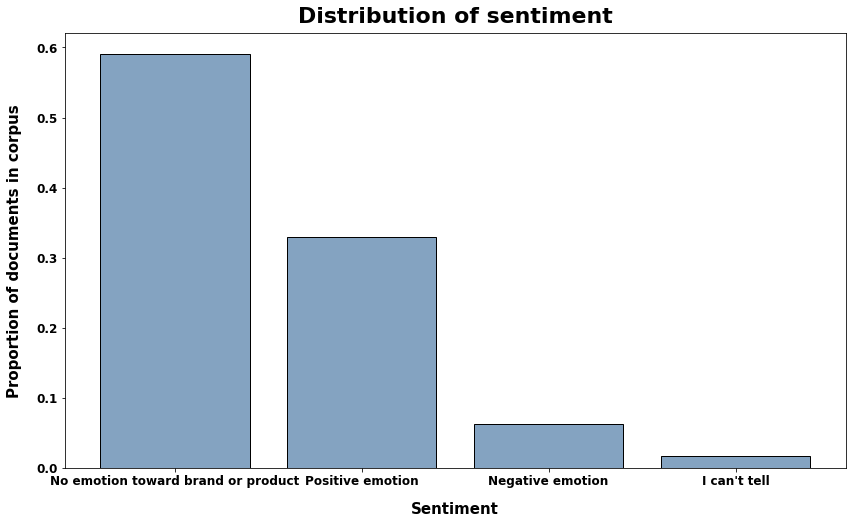

In [34]:
fig, ax = plt.subplots(figsize = (14, 8))

ax.bar(x = data_df.emotion.value_counts(normalize=True).index,
       height = data_df.emotion.value_counts(normalize=True).values,
       color = (0.2, 0.4, 0.6, 0.6),
       edgecolor = 'black')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.set_xlabel(xlabel="Sentiment",
              fontsize=15,
              labelpad=14)
ax.set_ylabel(ylabel="Proportion of documents in corpus",
              fontsize=15,
              labelpad=14)
ax.set_title(label="Distribution of sentiment",
             fontsize=22,
             pad=10);



print(f"Emotion value counts (normalized):\n{data_df.emotion.value_counts(normalize=True)}")

plt.savefig('images/Sentiment_Distribution.jpg',dpi='figure', 
        bbox_inches='tight', 
        facecolor='auto', 
       )

`I can't tell` makes up less than 2% of our dataset, and doesn't offer much more information in the way of word significance than the tweets labeled `No emotion toward brand or product`. We will drop records where `emotion` has been recorded as `I can't tell`.

In [35]:
data_df.drop(
    index = data_df[data_df.emotion == "I can't tell"].index,
    inplace = True)

data_df.shape

(8569, 3)

There is still a major imbalance in our dataset. Unfortunately, with a dataset this small, dropping any more records than absolutely necessary is not recommended. \
We may be able to supplement the data set down the line, but for now, we will continue with the dataset as is.

### StopWords

When working with webscraping and social data mining applications, or NLP problems in general, one of the problems that crops up is there is a large number of words that are commonly used. These words (such as 'a', 'are' etc) won't be able to uniquely identify with our `emotion` column since they are so widely used. \
We will be implementing nltk's stopwords module to remove such commonly used english words, here is a few examples of such words.

In [36]:
sw[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

But we can improve upon this. To do so lets have a quick look at the most frequently used words across all tweets.

In [37]:
# Lower case all text, remove punctuations, ignore stop words, get word frequency
getTopWordFreq(data_df,'text',n=10,stop_words = sw)

[('sxsw', 9096),
 ('link', 4077),
 ('rt', 2925),
 ('ipad', 2836),
 ('google', 2329),
 ('apple', 2093),
 ('quot', 1582),
 ('iphone', 1492),
 ('store', 1397),
 ('new', 1057)]

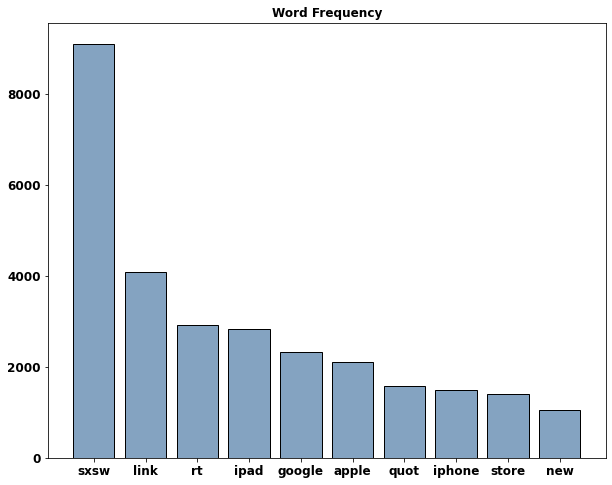

In [38]:
# Plot most frequent words
fig, ax = plt.subplots(figsize=(10, 8))
num_of_bars = 10
viz_data = getTopWordFreq(data_df, 'text', n=num_of_bars, stop_words=sw)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_title('Word Frequency')

ax.bar(x=[word for word, freq in viz_data],
       height=[freq for word, freq in viz_data],
       color=(0.2, 0.4, 0.6, 0.6),
       edgecolor='black');

plt.savefig('images/WordFreq_preSW.jpg',dpi='figure', 
        bbox_inches='tight', 
        facecolor='auto', 
       )

Just by looking at this, we can see there is a high occurence of 
- venue specific words such  as `sxsw`
- twitter specific words such as `rt`
- brand or product specific words such as `iphone`

These words probably occur across our various sentiments and may not necessarily add any meaning, unless a majority of their occurence is associated with a particular `emotion`

Instead of dropping words that just occur at a high frequency across the entire corpus, we will drop words that occur at a high frequency across our positive _and_ negative emotional quotient.

This should ensure we don't accidentally remove a word from the corpus that is overall heavily represented but is mostly represented in any 1 `emotion` and helps form a clearer delineation between the two emotions.

In [39]:
neg_df = data_df[data_df['emotion']=='Negative emotion']
pos_df = data_df[data_df['emotion']=='Positive emotion']

Sanity Check

In [40]:
neg_df.head(3)

,text,product_name,emotion
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
17,I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone,iPhone,Negative emotion


In [41]:
pos_df.head(3)

,text,product_name,emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


In [42]:
print('As an example. Here are the top 3 words:')
print(f"Entire DataFrame: {[word for word,freq in getTopWordFreq(data_df,'text',3,stop_words = sw)]}")
print(f"Positive Emotion: {[word for word,freq in getTopWordFreq(pos_df,'text',3,stop_words = sw)]}")
print(f"negative Emotion: {[word for word,freq in getTopWordFreq(neg_df,'text',3,stop_words = sw)]}")

As an example. Here are the top 3 words:
Entire DataFrame: ['sxsw', 'link', 'rt']
Positive Emotion: ['sxsw', 'ipad', 'link']
negative Emotion: ['sxsw', 'ipad', 'quot']


As you can tell, there is going to be a lot of crossover with certain terms (`sxsw`, `ipad` in our example above) which we should remove however, we'd want to retain words that are potentially more identifiable with a certain `emotion`. This is just the top 3 words, and we shall be using a larger set.\
Looking at the top 50 common words in both positive and negative `emotion` tweets, there 31 common words.

In [43]:
num_mostCommon_Words = 50
common_neg_words = [word for word,freq in getTopWordFreq(neg_df, 'text',num_mostCommon_Words,stop_words = sw)]
common_pos_words = [word for word,freq in getTopWordFreq(pos_df, 'text',num_mostCommon_Words,stop_words = sw)]
new_sw_words = list(set(common_neg_words).intersection(set(common_pos_words)))
print(len(new_sw_words))
new_sw_words

31


['one',
 'android',
 'apps',
 'social',
 'iphone',
 'store',
 'rt',
 'time',
 'people',
 "i'm",
 'link',
 'pop',
 'line',
 'good',
 'ipad',
 'launch',
 'amp',
 'apple',
 'get',
 'quot',
 'today',
 'day',
 'see',
 'sxsw',
 'like',
 'app',
 'new',
 'network',
 'google',
 'austin',
 'circles']

We shall be appending this to our stopword list. As part of our `doc_preparer()`, custom function to preprocess text, we shall be removing these words in the future

In [44]:
print(f'Original number of stopwords: {len(sw)}')
sw.extend(new_sw_words)
print(f'New number of stopwords:      {len(sw)}')

Original number of stopwords: 179
New number of stopwords:      210


Lets have a look at the word distribution again

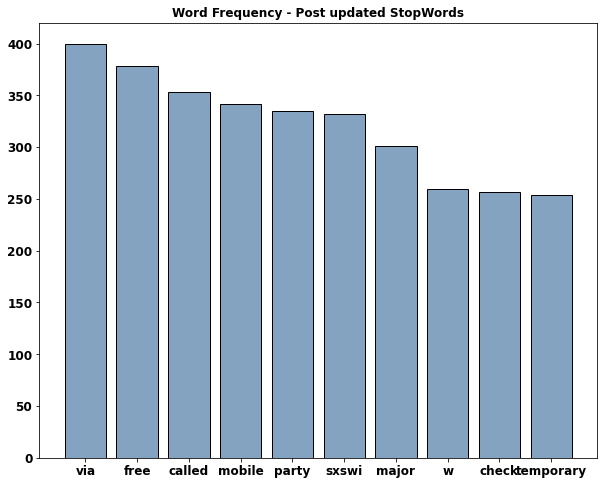

In [45]:
# Plot most frequent words
fig, ax = plt.subplots(figsize=(10, 8))
num_of_bars = 10
viz_data = getTopWordFreq(data_df, 'text', n=num_of_bars, stop_words=sw)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_title('Word Frequency - Post updated StopWords')

ax.bar(x=[word for word, freq in viz_data],
       height=[freq for word, freq in viz_data],
       color=(0.2, 0.4, 0.6, 0.6),
       edgecolor='black')

plt.savefig('images/WordFreq_postSW.jpg', dpi='figure',
            bbox_inches='tight',
            #             pad_inches=0.1,
            facecolor='auto',
            )

Already one can tell the word count is a little more normalized.

### Stemming the tweet text

We shall be creating a column of a cleaned text string built off of the original tweet

In [46]:
data_df['stemmed_text'] = data_df['text'].map(lambda x:doc_preparer(x,stem=True))

In [47]:
data_df[['text','stemmed_text']].head(5)

,text,stemmed_text
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iphon hr tweet rise dead need upgrad plugin station sxsw
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",know awesom ipad iphon app like appreci design also they'r give free ts sxsw
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,wait ipad also sale sxsw
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,hope year' festiv crashi year' iphon app sxsw
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",great stuff fri sxsw marissa mayer googl tim reilli tech book confer amp matt mullenweg wordpress


### Label Encoding the emotion column

To help with our classification models, we shall use a label encoder to encode the target `emotion` into a more computer friendly numerical column

In [48]:
le = LabelEncoder()
data_df['sentiment_target'] = le.fit_transform(data_df.emotion)
le.classes_

array(['Negative emotion', 'No emotion toward brand or product',
       'Positive emotion'], dtype=object)

In [49]:
data_df[['emotion', 'sentiment_target']].head(10)

,emotion,sentiment_target
0,Negative emotion,0
1,Positive emotion,2
2,Positive emotion,2
3,Negative emotion,0
4,Positive emotion,2
5,No emotion toward brand or product,1
7,Positive emotion,2
8,Positive emotion,2
9,Positive emotion,2
10,Positive emotion,2


# Train-Test-Split

In [50]:
X = data_df['stemmed_text']
y = data_df['sentiment_target']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

# Modeling

## `CountVectorizer()` with `DummyClassifier()`

In [51]:
#Pipeline
cvec_dummy_model_pipe = Pipeline([
    ('cvec',CountVectorizer()),
   ('dum',DummyClassifier(strategy = 'most_frequent')
   )
])

#5 fold Cross Validation
cvec_dummy_cvResults = cross_validate(cvec_dummy_model_pipe,
                                      X_train,
                                      y_train,
                                      scoring=('accuracy', 'f1_macro'),
                                      cv=5,
                                      verbose=1,
                                      n_jobs = NB_n_jobs,
                                      return_train_score=True)
prettyPrintCVScores(cvec_dummy_cvResults)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.602
Test accuracy:     0.602
F-1 Score
--------------------------------
Training F1 score: 0.250
Test F1 score:     0.250


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.5s finished


Our dummy classifier performs with 60% accuracy and 25% F1-score

## `CountVectorizer()` with `MutinomialNB()`

In [52]:
#Pipeline
cvec_mnb_model_pipe = Pipeline([
    ('cvec',CountVectorizer()),
   ('mnb',MultinomialNB()
   )
])

#5 fold Cross Validation
cvec_mnb_cvResults = cross_validate(cvec_mnb_model_pipe,
                                      X_train,
                                      y_train,
                                      scoring=('accuracy', 'f1_macro'),
                                      cv=5,
                                      verbose=1,
                                      n_jobs = NB_n_jobs,
                                      return_train_score=True)
prettyPrintCVScores(cvec_mnb_cvResults)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


CV Results
Accuracy
--------------------------------
Training accuracy: 0.818
Test accuracy:     0.676
F-1 Score
--------------------------------
Training F1 score: 0.733
Test F1 score:     0.519


We can already see some significant overfitting. This might be due to such a small and imbalanced dataset.

## `TfidfVectorizer()` with `MutinomialNB()`

In [53]:
#Pipeline
tvec_mnb_model_pipe = Pipeline([
    ('tvec',TfidfVectorizer()),
   ('mnb',MultinomialNB()
   )
])

#5 fold Cross Validation
tvec_mnb_cvResults = cross_validate(tvec_mnb_model_pipe,
                                      X_train,
                                      y_train,
                                      scoring=('accuracy', 'f1_macro'),
                                      cv=5,
                                      verbose=1,
                                      n_jobs = NB_n_jobs,
                                      return_train_score=True)
prettyPrintCVScores(tvec_mnb_cvResults)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.749
Test accuracy:     0.656
F-1 Score
--------------------------------
Training F1 score: 0.496
Test F1 score:     0.382


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


Using a TF-IDF vectorizer improves accuracy but at a major cost to the F1-score

## `CountVectorizer()` with `RandomForestClassifier()`

In [54]:
#Pipeline
cvec_rfc_model_pipe = Pipeline([
    ('cvec',CountVectorizer()),
   ('rfc',RandomForestClassifier(random_state=42)
   )
])

#5 fold Cross Validation
cvec_rfc_cvResults = cross_validate(cvec_rfc_model_pipe,
                                      X_train,
                                      y_train,
                                      scoring=('accuracy', 'f1_macro'),
                                      cv=5,
                                      verbose=1,
                                      n_jobs = NB_n_jobs,
                                      return_train_score=True)
prettyPrintCVScores(cvec_rfc_cvResults)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.994
Test accuracy:     0.691
F-1 Score
--------------------------------
Training F1 score: 0.995
Test F1 score:     0.541


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    5.8s finished


This is model is severely overfitting but it performs marginally better than the `MultinomialNB()` model

## `TfidfVectorizer()` with `RandomForestClassifier()`

In [55]:
#Pipeline
tvec_rfc_model_pipe = Pipeline([
    ('tvec',TfidfVectorizer()),
   ('rfc',RandomForestClassifier(random_state=42)
   )
])

#5 fold Cross Validation
tvec_rfc_cvResults = cross_validate(tvec_rfc_model_pipe,
                                      X_train,
                                      y_train,
                                      scoring=('accuracy', 'f1_macro'),
                                      cv=5,
                                      verbose=1,
                                      n_jobs = NB_n_jobs,
                                      return_train_score=True)
prettyPrintCVScores(tvec_rfc_cvResults)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.994
Test accuracy:     0.688
F-1 Score
--------------------------------
Training F1 score: 0.995
Test F1 score:     0.524


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    4.3s finished


## `CountVectorizer()` with `GradientBoostingClassifier()`

In [56]:
#Pipeline
cvec_gbc_model_pipe = Pipeline([
    ('cvec',CountVectorizer()),
   ('gbc',GradientBoostingClassifier(random_state=42)
   )
])

#5 fold Cross Validation
cvec_gbc_cvResults = cross_validate(cvec_gbc_model_pipe,
                                      X_train,
                                      y_train,
                                      scoring=('accuracy', 'f1_macro'),
                                      cv=5,
                                      verbose=1,
                                      n_jobs = NB_n_jobs,
                                      return_train_score=True)
prettyPrintCVScores(cvec_gbc_cvResults)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.728
Test accuracy:     0.670
F-1 Score
--------------------------------
Training F1 score: 0.564
Test F1 score:     0.443


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.1s finished


## `TfidfVectorizer()` with `GradientBoostingClassifier()`

In [57]:
#Pipeline
tvec_gbc_model_pipe = Pipeline([
    ('tvec',TfidfVectorizer()),
   ('gbc',GradientBoostingClassifier(random_state=42)
   )
])

#5 fold Cross Validation
tvec_gbc_cvResults = cross_validate(tvec_gbc_model_pipe,
                                      X_train,
                                      y_train,
                                      scoring=('accuracy', 'f1_macro'),
                                      cv=5,
                                      verbose=1,
                                      n_jobs = NB_n_jobs,
                                      return_train_score=True)
prettyPrintCVScores(tvec_gbc_cvResults)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.743
Test accuracy:     0.663
F-1 Score
--------------------------------
Training F1 score: 0.595
Test F1 score:     0.440


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.0s finished


## `CountVectorizer()` with `XGBRFClassifier()`

In [58]:
#Pipeline
cvec_xgb_model_pipe = Pipeline([
    ('cvec',CountVectorizer()),
   ('xgb',xgboost.XGBRFClassifier(random_state=42)
   )
])

#5 fold Cross Validation
cvec_xgb_cvResults = cross_validate(cvec_xgb_model_pipe,
                                      X_train,
                                      y_train,
                                      scoring=('accuracy', 'f1_macro'),
                                      cv=5,
                                      verbose=1,
                                      n_jobs = NB_n_jobs,
                                      return_train_score=True)
prettyPrintCVScores(cvec_xgb_cvResults)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.665
Test accuracy:     0.644
F-1 Score
--------------------------------
Training F1 score: 0.416
Test F1 score:     0.374


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.7s finished


## `TfidfVectorizer()` with `XGBRFClassifier()`

In [59]:
#Pipeline
tvec_xgb_model_pipe = Pipeline([
    ('tvec',TfidfVectorizer()),
   ('gbc',xgboost.XGBRFClassifier(random_state=42)
   )
])

#5 fold Cross Validation
tvec_xgb_cvResults = cross_validate(tvec_xgb_model_pipe,
                                      X_train,
                                      y_train,
                                      scoring=('accuracy', 'f1_macro'),
                                      cv=5,
                                      verbose=1,
                                      n_jobs = NB_n_jobs,
                                      return_train_score=True)
prettyPrintCVScores(tvec_xgb_cvResults)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.685
Test accuracy:     0.642
F-1 Score
--------------------------------
Training F1 score: 0.451
Test F1 score:     0.375


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    4.1s finished


# Hypertuning best model

Our count vectorized > random forest model worked best. Hypertuning it

In [60]:
params = {}
params['rfc__criterion'] = ['gini','entropy']
params['rfc__n_estimators'] = np.arange(50,250,50)
params['rfc__max_depth'] = np.arange(100,200,10)
# params['rfc__max_leaf_nodes']=[4000,4500,5000]

cvec_rfc_model_pipe = Pipeline([
    ('cvec',CountVectorizer()),
   ('rfc',RandomForestClassifier(random_state=42)
   )
])

cvec_rfc_gs = GridSearchCV(estimator=cvec_rfc_model_pipe,
                           param_grid=params,
                           n_jobs=NB_n_jobs,
                           scoring=[ 'accuracy','precision_macro','recall_macro','f1_macro'],
                           refit='accuracy',
                           return_train_score=True)

cvec_rfc_gs.fit(X_train,y_train)
prettyPrintGridCVResults(cvec_rfc_gs)

,Mean Test Accuracy,Mean Test Precision (macro),Mean Test Recall (macro),Mean Test F1-Score (macro),param_rfc__criterion,param_rfc__max_depth,param_rfc__n_estimators
Rank (By Accuracy),,,,,,,
1,0.6966,0.7123,0.4970,0.5272,gini,130,150
2,0.6951,0.7046,0.5075,0.5408,gini,190,150
3,0.6951,0.7116,0.5045,0.5372,gini,170,200
4,0.6947,0.7091,0.5036,0.5359,gini,170,150
5,0.6946,0.7121,0.4926,0.5211,gini,130,50
...,...,...,...,...,...,...,...
76,0.6864,0.6900,0.5024,0.5345,entropy,170,50
77,0.6862,0.6956,0.4887,0.5168,gini,140,50
78,0.6862,0.7054,0.4807,0.5064,gini,120,50


In [61]:
final_model = cvec_rfc_gs.best_estimator_


filePath = f'model/{final_model=}'.split('=')[0] + '.sav'
pickle.dump(final_model, open(filePath, 'wb'))

In [71]:
cr = classification_report(y_test, final_model.predict(X_test))
print(cr)

              precision    recall  f1-score   support

           0       0.69      0.12      0.21       164
           1       0.69      0.89      0.78      1546
           2       0.66      0.41      0.51       861

    accuracy                           0.68      2571
   macro avg       0.68      0.48      0.50      2571
weighted avg       0.68      0.68      0.65      2571



Overall accuracy is around 69% with an F1-Score of 67%

In [ ]:
cm = confusion_matrix(y_test, final_model.predict(X_test))

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay.from_estimator(
        final_model,
        X_test,
        y_test,
        display_labels=le.classes_,
        cmap='OrRd',
        normalize='true',
        ax=ax
       ).ax_.set_title('Normalized Confusion Matrix')

As can be seen our model has a long way to go. Currently the model performs its worst with clasiffying `Negative emotion` and best at `No emotion toward brand or product`. This is primarily due to a heavy imbalance in the classes.
Techniques to over come the imbalance will need to be employed.

# Future Steps

Potential upsampling techniques to be utilised:
- Backtranslation on minority sample to augment our tweet text data
- Synonymising the minority sample to augment our tweet text data
- SMOTEing the the minority sample to augment our tweet text data